# Computer Tomography Completed by Andrea Lemez

## Introduction

In this notebook we will inspect a CT medical image. We will focus on the following examples:

* Calculating the density of bone from DICOM metadata
* Segmentation
* Filtering
* 3D rendering

## Image Formation

Computer Tomography is the generalized term used for tomographic images obtained using X-Rays which pass through the patient. The image is formed by the anti-scattered light that reaches the detector and is then converted into light. When the X-rays strike the detector they release electrons that are trapped and converted into light (scintillator). For digital detectors we then convert this light into electronic signals that are acquired to form an image.

The image pixels are formed through a "negative" principle since X-rays will reach the detector only when not absorbed by the body. The image is coded with an intensity value that is directly proportional to the absorption and this relative intensity is what is stored in a DICOM file. These units will not be a physical characteristic of the body but a relative unit defined to use the maximum dynamic of the storage space. We can nevertheless rescale the image to obtain the density using conversion to Hounsfield Units (HU). Hounsfield units is a standardized measurement system that is based on the attenuation coefficient of a measured medium, air, and water. The HU gives us a measurement of bone density. The HU is defined as:

$$HU=1000 \frac{\mu - \mu_{water}}{\mu_{water}-\mu_{air}}$$

where $\mu$ is the measured attenuation of the beam in the medium, $\mu_{water}$ and $\mu_{air}$ are the attenuation in water and air at standard atmospheric pressure and temperature. 

In the DICOM file the intensity is stored using a linear relationship between the measured attenuation and its equivalent HU unit and the conversion can be performed with a linear equation:

$$HU=m \times intensity + b$$

where $m$ is a slope stored in the metadata **RescaleSlope** and $b$ is stored in **RescaleIntercept**

We will implement below a conversion from the image pixels in a CT image into HU.


Note: there are 185 files provided for multiple slices of this image. We will work with image 100.

**NOTE: IF RUNNING IN AZURE NOTEBOOKS MAKE SURE YOU USE A PYTHON 3 KERNEL **

In [1]:
!pip install pydicom

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


(0008, 0000) Group Length                        UL: 566
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20080603'
(0008, 0013) Instance Creation Time              TM: '073128'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113619.2.55.3.1284421438.720.1212483672.467.100
(0008, 0020) Study Date                          DA: '20080603'
(0008, 0021) Series Date                         DA: '20080603'
(0008, 0022) Acquisition Date                    DA: '20080603'
(0008, 0023) Content Date                        DA: '20080603'
(0008, 0030) Study Time                          TM: '072857'
(0008, 0031) Series Time                         TM: '073007'
(0008, 0032) Acquisition Time                    TM: '073017'
(0008, 0033) Content Time                   

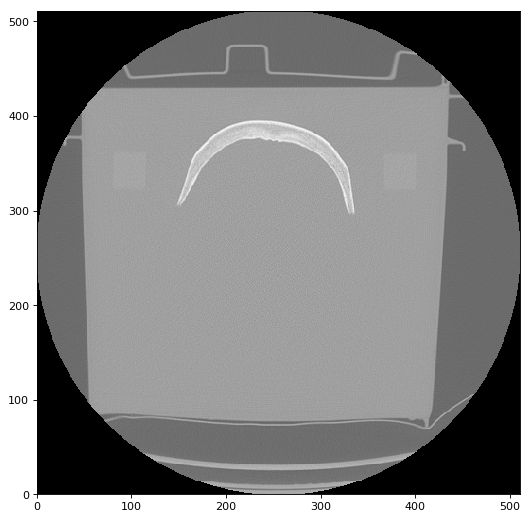

In [2]:
# As usual we will have the magic command for figures inline, but you can use interactive nbagg if you prefer
%matplotlib inline

# And we will start by importing the numerical and ploting packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

# As well as the DICOM package
import pydicom

# Get file
RefDs = pydicom.read_file('./DICOMs/im100')
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))
# Then initialize in zeros an array
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
# Finally we had already read the file and we have the image information in the pixel_array (final field)
ArrayDicom[:,:]=RefDs.pixel_array
# Some rendering tools here to set the size of that image to a specific value dpi and equal axis or square image as well
# as work with grayscale
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
plt.axes().set_aspect('equal') #this makes the image square
plt.set_cmap(plt.gray()) #grayscale
# Colormesh will require a horizontal and vertical axes
Rows=np.arange(RefDs.Rows)
Columns=np.arange(RefDs.Columns)
# This is the actual rendering
plt.pcolormesh(Rows, Columns, np.flipud(ArrayDicom[:, :]))

# And we will inspect the metadata here
print(RefDs)

### Activity 1 - From inspecting the metadata and the rendered image answer: 1) what is the model of the CT scanner used? 2) when was this image taken? 3) what is the slice thickness for this image? 4) this image is made from a phantom that is submerged in a plastic container, what anatomical part is the phantom of?
<br><font color=green>
1) This is a GE Medical Systems CT Scanner model LightSpeed VCT
<br>
2) 2008/06/03
<br>
3) Slice thickness==> DS: "0.625000"
<br>
4) A petrous bone</font>

## Segmentation

We will now segment the bone only (brightest pixels). In this example we will segment our image into two regions simply dividing them by intensity values. The dark pixels will be in a region called **1**, the lighter pixels will be in **2**. We will perform this segmentation using thresholding.

Text(0.5,1,'Segmented Mask')

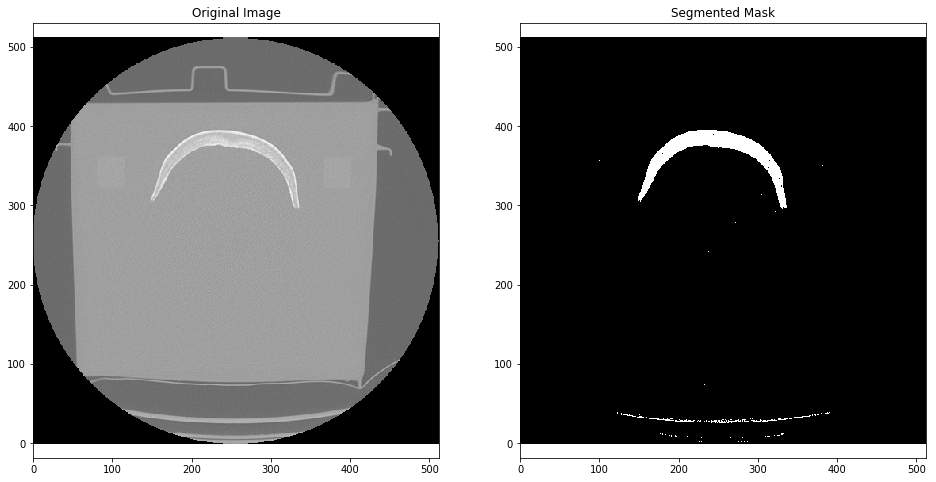

In [3]:
Threshold = 1300

mask = np.zeros_like(ArrayDicom,'uint8')
mask[ArrayDicom <= Threshold] = 0          
mask[ArrayDicom > Threshold] = 1

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(np.flipud(ArrayDicom))
plt.axis('equal') #this makes the image square
plt.title('Original Image')
plt.subplot(122)
plt.pcolormesh(np.flipud(mask))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask')

This simple segmentation is effective but we have detected regions other than the bone, so we will need to separate regions so we can obtain the calculations only for the bone.

Text(0.5,1,'Segmented Mask Regions out of 77 regions detected')

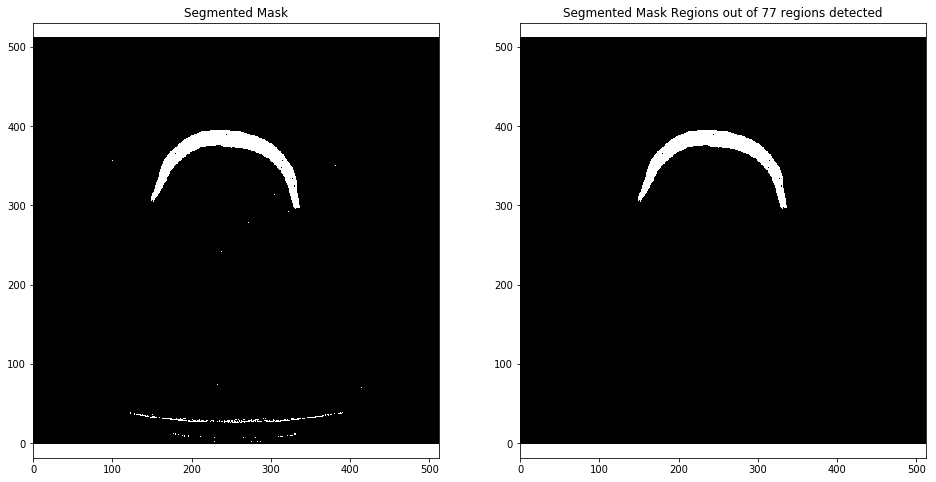

In [4]:
import cv2

plt.figure(figsize=(16, 8))
ret, markers = cv2.connectedComponents(mask)  #this will detect all the regions within the mask
# to determine which of the regions has the highest number of pixels we can use a histogram
hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
# the highest number of pixels are evidently on the black, so we look for the second highest
inxhist=np.argsort(hist)  #indexes of the sorted histogram
inxbone=inxhist[-2]  #this is the index of the second last region (the last being the most frequent)
ROI=np.zeros_like(ArrayDicom,'uint8')
ROI[np.where(markers==inxbone)]=1   #we turn to 1 only those pixels that are in that second most frequent region

plt.subplot(121)
plt.pcolormesh(np.flipud(mask))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask')
plt.subplot(122)
plt.pcolormesh(np.flipud(ROI))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask Regions out of '+str(ret)+' regions detected')

### Activity 2 - From the markers array before make an array with only 5 regions, each region a different color, and plot the markers array to see the 5 regions with the most pixels. Tip: use *plt.imshow(ARRAY,cmap=cm.hot)* which will need *import matplotlib.cm as cm* so you can visualize easier the 5 regions [grayscale should still work]

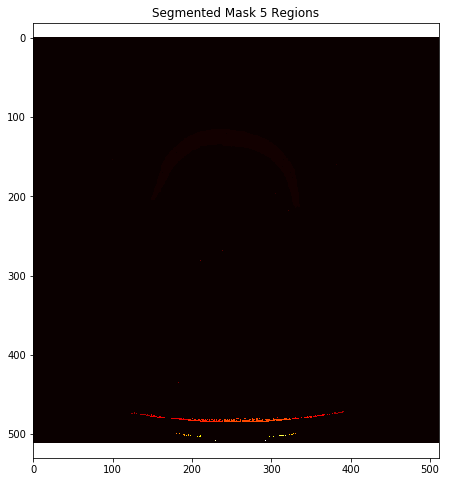

In [5]:
####Activity 5######
import matplotlib.cm as cm

ret2, markers2 = cv2.connectedComponents(mask)
hist2,bins2 = np.histogram(markers.flatten(),5,[0,5]) #ininstead of ret, 5 regions specified
inxhist2=np.argsort(hist2)  #indexes of the sorted histogram
inxbone2=inxhist2[-2]  #this is the index of the second last region (the last being the most frequent)
ROI2=np.zeros_like(ArrayDicom,'uint8')
ROI2[np.where(markers==inxbone)]=1   #we turn to 1 only those pixels that are in that second most frequent region


plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask 5 Regions')
plt.imshow(markers2, cmap = cm.hot)


We will now use that mask to obtain the intensities in the original image for the detected region and convert into HU. Then obtain the average density for that bone.

Text(0.5,1,'Segmented Image - HU: Average is 852.0964912280701 HU')

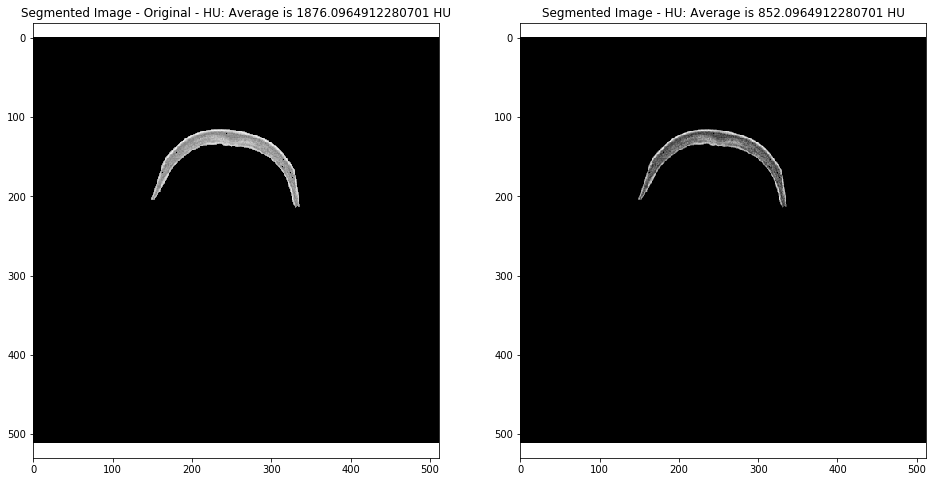

In [6]:
# We will first convert all the image to HU
CorrectedImage=RefDs.RescaleSlope*ArrayDicom+RefDs.RescaleIntercept
# Then obtain only the segmented Image in HU
SegmentedIm=ROI*CorrectedImage
SegmentedImNonCorrected=ArrayDicom*ROI
# And obtain an array of those intensities
intensity = SegmentedIm[np.where(ROI==1)] #Creating an array that contain only the bone pixels
intensityNonCorrected = SegmentedImNonCorrected[np.where(ROI==1)] #Creating an array that contain only the bone pixels before correction
# Now the average of that array is the average HU for the region
AvDensity=np.mean(intensity)
AvDensityNonCorrected=np.mean(intensityNonCorrected)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(SegmentedImNonCorrected)
plt.axis('equal') #this makes the image square
plt.title('Segmented Image - Original - HU: Average is '+str(AvDensityNonCorrected)+' HU')
plt.subplot(122)
plt.imshow(SegmentedIm)
plt.axis('equal') #this makes the image square
plt.title('Segmented Image - HU: Average is '+str(AvDensity)+' HU')


For bone we expect a value between 700 and 3000 HU. For a skull we expect around 800 HU in average. Either method gives a value within the ranges for bone, but the correction does give a value that is closer to the expected density for skull bone.

# Challenge \# 8 

In the code above we have obtained the average moving into an array all the values within the mask and using numpy .mean
There is an implementation possible using scipy that can directly create the labels and we can then obtain the mean for each of the labels.

Implement that code without using cv2 for finding regions nor numpy for averaging but using scipy to obtain both the labels and the mean.

## Volume Segmentation

We have already segmented one of the images here. We will code now a segmentation algorithm for all the images that were obtained with this CT and create a 3D array of the bone.

The segmentation before with automatic determination of the region with the bone using the second largest region will not work for all the images in the series. This is because the first images will have a very low amount of bone (first slices).

Because we observe that the bone is in the top part of the image we will first eliminate anything on the bottom and then run the segmentation for all images.

Text(0.5,1,'Segmented Mask')

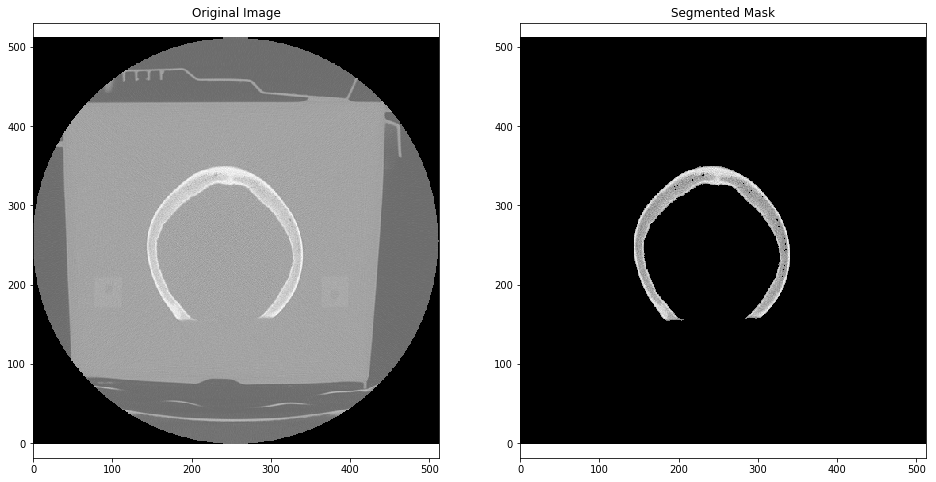

In [7]:
InFile=57
FinalFile=241
IndexBottom=400

fname='./DICOMs/im{:d}'.format(100)
RefDs = pydicom.read_file(fname)
ArrayDicom3D = np.zeros((FinalFile-InFile+1,RefDs.Rows,RefDs.Columns), dtype=RefDs.pixel_array.dtype)
SegmentedArrayDicom3D = np.zeros((FinalFile-InFile+1,RefDs.Rows,RefDs.Columns), dtype=RefDs.pixel_array.dtype)

for ix in range(InFile,FinalFile+1):
    # Get file
    fname='./DICOMs/im{:d}'.format(ix)
    RefDs = pydicom.read_file(fname)
    # Finally we had already read the file and we have the image information in the pixel_array (final field)
    ArrayDicom3D[ix-InFile,:,:]=RefDs.pixel_array

Threshold = 1300

mask3D = np.zeros_like(ArrayDicom3D,'uint8')
mask3D[ArrayDicom3D <= Threshold] = 0          
mask3D[ArrayDicom3D > Threshold] = 1
mask3D[:,IndexBottom:512,0:512] = 0   #this eliminates the bottom of the image

TotImages=len(ArrayDicom3D[:,1,1])

for ix in range(0,TotImages):
    ret, markers = cv2.connectedComponents(mask3D[ix])  #this will detect all the regions within the mask
    #plt.imshow(mask3D[ix])    #uncomment this line and the next if you want to see all the masks
    #plt.show()
    # to determine which of the regions has the highest number of pixels we can use a histogram
    hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
    # the highest number of pixels are evidently on the black, so we look for the second highest
    inxhist=np.argsort(hist)  #indexes of the sorted histogram
    inxbone=inxhist[-2]  #this is the index of the second last region (the last being the most frequent)
    ROI=np.zeros_like(ArrayDicom3D[ix],'uint8')
    ROI[np.where(markers==inxbone)]=1   #we turn to 1 only those pixels that are in that second most frequent region
    SegmentedArrayDicom3D[ix,:,:]=ROI*ArrayDicom3D[ix,:,:]   #segmenting the image only to bone
    
SegmentedArrayDicom3D=RefDs.RescaleSlope*SegmentedArrayDicom3D+RefDs.RescaleIntercept  # Conversion to HU

#You can visualize one of the images changing the value here
VisImage=130

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(np.flipud(ArrayDicom3D[VisImage]))
plt.axis('equal') #this makes the image square
plt.title('Original Image')
plt.subplot(122)
plt.pcolormesh(np.flipud(SegmentedArrayDicom3D[VisImage]))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask')

### Activity 3 - Visualize some images by modifying the code above where indicated and indicate in which orientation this bone is (where is the top/bottom, right/left and front/back of the person).
<font color=green>
I modified the VisImage variable to 80 and to 150 to see different images. The petrous bone is part of the temporal bone on either side of a person's skull, and this is an axial slice. From that information I can deduce that the top of the person is most likely in the plane facing out of the computer screen (positive z direction) and the bottom of the person is thus in the negative z direction. I am not a biomed student and I had a very hard time finding what a petrous bone looks like when imaged with the rest of the skull so I am making an educated guess that the right of the patient is the bottom of the image (making left of the patient the top) and the front is the right side (making the back the left).  
    </font>

## Filtering

We will finally see the effects of filtering on the image and we will work on the segmented bone. As done before, we will use a high pass filter but we will also implement a low pass filter.

To smooth an image (low pass) we will try here a **Gaussian filter**. It achieves filtering by convolving the image with a kernel of Gaussian values which will do a Gaussian averaging of pixels. We can use the *gaussian_filter* funtion implemented in *scipy* where the dimension of the matrix for this convolution is defined.

We used a **Sobel** filter to enhance the edges (high pass). There are other high pass filters that can be used for sharpening images sugh as **Laplacian**. The Laplacian filter performs a 2nd spatial derivative of an image and thus enhances rapid intensity change which is also an edge detection method or a high pass filter. The Laplacian is very effective when an image was smoothed by averaging which is a common blurring effect on images. We can use the *laplace_filter* funtion implemented in *scipy* where the dimension of the matrix for this convolution is defined.

Text(0.5,1,'Original Image Sobel filtered - High Pass')

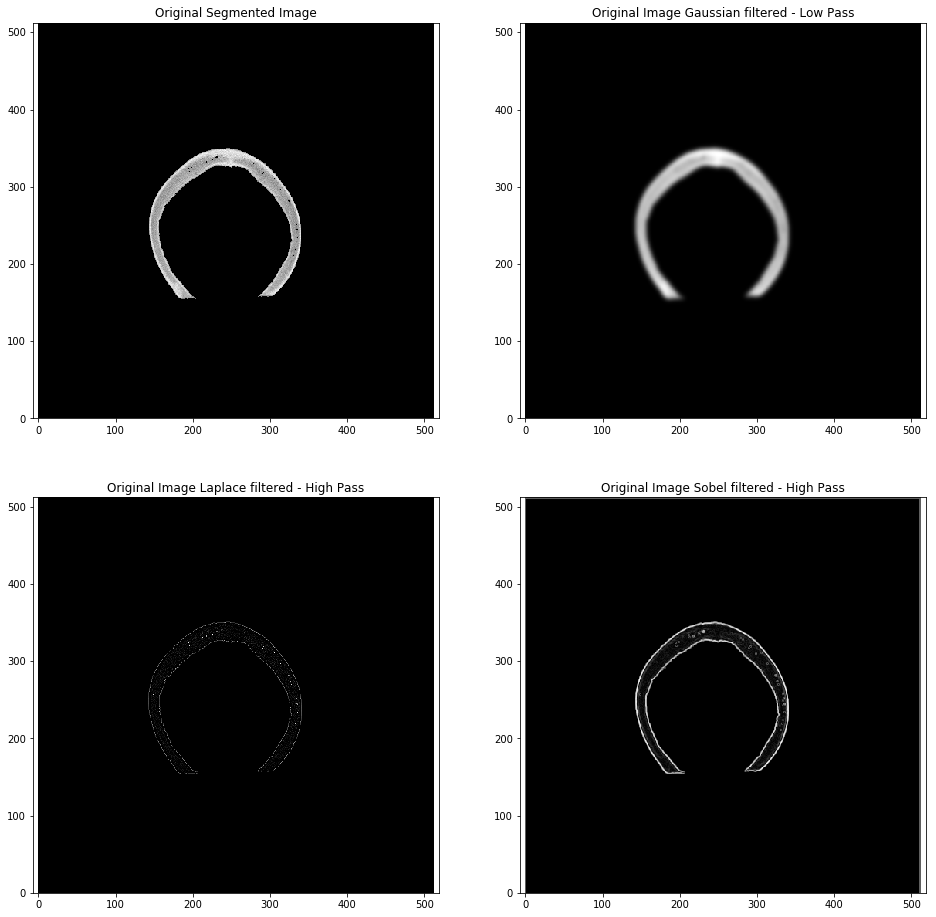

In [8]:
from scipy import ndimage

# LOW Pass
# Gaussian filter to smooth the image
ImageGaussian=ndimage.gaussian_filter(SegmentedArrayDicom3D[VisImage], sigma=3)

# HIGH PASS
# From the previous implementation of the Sobel filter
ImageSobelFx=ndimage.sobel(SegmentedArrayDicom3D[VisImage],axis=0, mode='constant')
ImageSobelFy=ndimage.sobel(SegmentedArrayDicom3D[VisImage],axis=1, mode='constant')
ImageSobelF=np.hypot(ImageSobelFx, ImageSobelFy)
# And the Laplace filter
ImageGaussianLaplace=ndimage.laplace(SegmentedArrayDicom3D[VisImage])
ImageGaussianLaplace[np.where(ImageGaussianLaplace<0)]=0

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.pcolormesh(np.flipud(SegmentedArrayDicom3D[VisImage]))
plt.axis('equal') #this makes the image square
plt.title('Original Segmented Image')
plt.subplot(222)
plt.pcolormesh(np.flipud(ImageGaussian))
plt.axis('equal') #this makes the image square
plt.title('Original Image Gaussian filtered - Low Pass')
plt.subplot(223)
plt.pcolormesh(np.flipud(ImageGaussianLaplace))
plt.axis('equal') #this makes the image square
plt.title('Original Image Laplace filtered - High Pass')
plt.subplot(224)
plt.pcolormesh(np.flipud(ImageSobelF))
plt.axis('equal') #this makes the image square
plt.title('Original Image Sobel filtered - High Pass')

### Activity 3 - Modify the size of the Gaussian filter and make observations on the resulting image.
<font color=green>Increasing the kernel size of the Gaussian figure really blurs the Gaussian Filtered image, and creates a halo around the edges. Even a kernel size of one produes some visible blur. </font>

### Activity 4 - Add a code cell to run a low pass filter on an image and then a high pass filter on that resulting image and plot the resulting original and filtered image. Make observations on the resulting image.
<font color=green>The resulting image has a very clearly defined outline. The edges are still somewhat blurred as per the work of the low pass filter. The middle of the bone is information that was lost when the high pass filter was applied. As we know, high pass filters keep only the higher frequencies which are found at the periphery.</font>

Text(0.5,1,'Original Image Low Pass then High Pass Filter')

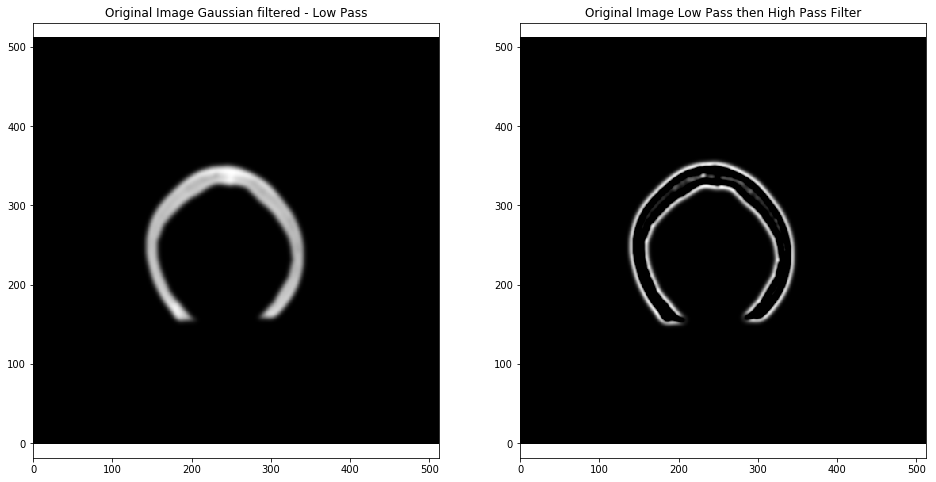

In [9]:
####Activity 4########

#Low Pass filter
ImageGaussianLPF=ndimage.gaussian_filter(SegmentedArrayDicom3D[VisImage], sigma=3)

#High Pass Laplace Filter
ImageGaussianLaplaceHPF=ndimage.laplace(ImageGaussianLPF)
ImageGaussianLaplaceHPF[np.where(ImageGaussianLaplaceHPF<0)]=0

plt.figure(figsize =(16,8))
plt.subplot(121)
plt.pcolormesh(np.flipud(ImageGaussianLPF))
plt.axis('equal') #this makes the image square
plt.title('Original Image Gaussian filtered - Low Pass')
plt.subplot(122)
plt.pcolormesh(np.flipud(ImageGaussianLaplaceHPF))
plt.axis('equal')
plt.title('Original Image Low Pass then High Pass Filter')

## 3D Rendering

We will finally make a volumetric rendering of this image. For this, we need to generate a mesh of triangles and vertices out of our segmented data. 

An algorithm that is widely used for this purpose is the **marching cubes**. This algorithm extracts a polygonal mesh of an isosurface from a three-dimensional discrete scalar field (our 3D mask). It is widely used for visualizations of CT and MRI scans.

The algorithm uses eight contigous pixels locations at a time to form a cube (each pixel is a vertix) and determines which of the possible series of polygons within this cube is the most appropriate depending on the pixel being on or off. 

![MarchingCubes.jpg](https://raw.githubusercontent.com/lcurielramirez/BMEN509-N4-CT/master/MarchingCubes.jpg)

Finally each vertex of the generated polygons is placed on the appropriate position along the edge by linearly interpolating the two scalar values obtained for the neighbouring cubes.

This algorithm has been implemented in *skimage*.

In [10]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import interact_manual, interact

def make_mesh(image, threshold=5, step_size=1):
    p=image
    # generation of the vertices and faces of polygons using marching cubes
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plt_3d(verts, faces, orientationX, orientationY):
 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    x,y,z = zip(*verts) 
    
    # verts[faces] generates a collection of triangles which is needed by Poly3DCollection
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    
    face_color = [0.89, 0.85, 0.79]    #bone colour
    mesh.set_facecolor(face_color)    
    mesh.set_edgecolor([0,0,0])    #black
    ax.add_collection3d(mesh)    #creates the volume image

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    
    ax.view_init(orientationX, orientationY)   #sets the orientation of the view
    
    plt.show() 
   
verts, faces = make_mesh(SegmentedArrayDicom3D, 350)   #calls function to create mesh
%prun -r plt_3d(verts, faces, 30,60);   #calls function to plot and opens a pager with execution information

ImportError: cannot import name '_validate_lengths'

### Activity 5 - Copy the code above and simplify the image in 3D using the simplest technique: subsample your 3D image so that you keep the same amount of images but only 1/4 of the 512x512 image. Discuss how the execution time and visualization were affected by this subsampling.
<br> <font color=red> I had an Import Error that I could not solve so I never actually got to run this activity. I would assume though that execution time would be faster with 3/4 of the 512x512 image now gone, and visualization would be worse. </font>

# Challenge \# 9

This implementation of a surface requires the use of scikit-image.marching_cubes. This algorithm is very slow and there is two different open source implementations that propose to use a more efficient solution.

Find one of those solutions, install it on the computer you are working on (make sure you do this on your Python path) and implement a cell code bellow that uses that implementation instead of scikit-image.

## Summary

In this example we:

* Showed how to open and inspect a DICOM image from a CT scan
* Obtained the adjusted information for density in Hounsfield Units from the intensity of pixels in the CT scan
* Segmented the bone fron a CT image and obtained the average density 
* Performed segmentation over the whole CT volume acquired and rendered a 3D image
* Filtered the CT image using high and low pass filters
* Made a simplification on the volumetric data for faster 3D rendering

Comments and corrections welcome!

References
---------------

* Tinku Acharya and Ajoy K. Ray, *Image Processing - Principles and Applications*. Wiley InterScience, 2006.
* https://docs.scipy.org
* Laprairie, Mark JW, and Howard J. Hamilton. "Isovox: A Brick-Octree Approach to Indirect Visualization."